In [1]:
import os
import sys
sys.path.append("/n/home12/binxuwang/Github/Closed-loop-visual-insilico")
import timm
import torch
import torch as th
import torch.nn as nn
from torchvision.models.feature_extraction import create_feature_extractor
from tqdm.auto import tqdm
from os.path import join
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from horama import maco, plot_maco
import torchvision.transforms as T
from torchvision.transforms import ToPILImage, ToTensor, Normalize, Resize
from torchvision.models import resnet50
from circuit_toolkit.CNN_scorers import TorchScorer
from circuit_toolkit.GAN_utils import upconvGAN, Caffenet
from circuit_toolkit.plot_utils import to_imgrid, show_imgrid, save_imgrid, saveallforms
from circuit_toolkit.layer_hook_utils import featureFetcher_module, featureFetcher, get_module_names
from circuit_toolkit.dataset_utils import ImagePathDataset
from torch.utils.data import DataLoader
from neural_regress.regress_lib import sweep_regressors
from neural_regress.sklearn_torchify_lib import SRP_torch, PCA_torch, LinearRegression_torch, SpatialAvg_torch

import seaborn as sns
import pandas as pd

import sklearn
from sklearn.pipeline import make_pipeline
from sklearn.random_projection import SparseRandomProjection, GaussianRandomProjection
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeCV
from sklearn.decomposition import PCA
from sklearn.kernel_ridge import KernelRidge

#%% Utility Functions

from core.data_utils import load_from_hdf5
def load_neural_data(data_path, subject_id, stimroot):
    """Load neural data and image file paths."""
    data = load_from_hdf5(data_path)
    # Meta data
    brain_area = data[subject_id]["neuron_metadata"]["brain_area"]
    ncsnr = data[subject_id]["neuron_metadata"]["ncsnr"]
    reliability = data[subject_id]["neuron_metadata"]["reliability"]
    # Display parameters
    stim_pos = data[subject_id]['trials']['stimulus_pos_deg']
    stim_size = data[subject_id]['trials']['stimulus_size_pix']
    # Response data
    resp_mat = data[subject_id]['repavg']['response_peak']  # Peak, avg response
    resp_temp_mat = data[subject_id]['repavg']['response_temporal']  # Temporal response
    stimulus_names = data[subject_id]['repavg']['stimulus_name']
    image_fps = [f"{stimroot}/{stimname.decode('utf8')}" for stimname in stimulus_names]
    return {
        'brain_area': brain_area,
        'ncsnr': ncsnr,
        'reliability': reliability,
        'stim_pos': stim_pos,
        'stim_size': stim_size,
        'resp_mat': resp_mat,
        'resp_temp_mat': resp_temp_mat,
        'image_fps': image_fps,
    }


def create_response_tensor(trials_stim_names, trials_resp_peak, rspavg_stim_names):
    """Create a 3D tensor (stimulus x neuron x trial) from trial responses.
    
    Args:
        trials_stim_names: Array of stimulus names for each trial
        trials_resp_peak: Array of peak responses for each trial (trial x neuron)
        rspavg_stim_names: Array of unique stimulus names
        
    Returns:
        resp_tensor: 3D tensor of responses (stimulus x neuron x max_trials)
        trial_counters: Number of trials per stimulus
    """
    # Create a dictionary mapping stimulus names to indices
    stim_to_idx = {name.decode('utf8'): i for i, name in enumerate(rspavg_stim_names)}
    # Initialize list to store trial counts for each stimulus
    trial_counts = np.zeros(len(rspavg_stim_names), dtype=int)
    # Count trials per stimulus
    for stim_name in trials_stim_names:
        trial_counts[stim_to_idx[stim_name.decode('utf8')]] += 1
    max_trials = trial_counts.max()
    # Initialize 3D tensor (stimulus x neuron x trial)
    resp_tensor = np.full((len(rspavg_stim_names), trials_resp_peak.shape[1], max_trials), np.nan)
    trial_counters = np.zeros(len(rspavg_stim_names), dtype=int)
    # Fill in the tensor with trial responses
    for trial_idx, (stim_name, trial_resp) in enumerate(zip(trials_stim_names, trials_resp_peak)):
        stim_idx = stim_to_idx[stim_name.decode('utf8')]
        resp_tensor[stim_idx, :, trial_counters[stim_idx]] = trial_resp
        trial_counters[stim_idx] += 1

    print(f"Response tensor shape (stimulus x neuron x trial): {resp_tensor.shape}")
    return resp_tensor, trial_counters


def load_neural_trial_resp_tensor(data_path, subject_id,):
    data = load_from_hdf5(data_path)
    trials_stim_names = data[subject_id]['trials']['stimulus_name']
    trials_resp_peak = data[subject_id]['trials']['response_peak']
    rspavg_stim_names = data[subject_id]['repavg']['stimulus_name']
    rspavg_resp_peak = data[subject_id]['repavg']['response_peak']
    print("Trials shape:", trials_stim_names.shape, trials_resp_peak.shape)
    print("Rspavg shape:", rspavg_stim_names.shape, rspavg_resp_peak.shape)
    resp_tensor, trial_counters = create_response_tensor(trials_stim_names, trials_resp_peak, rspavg_stim_names)
    print("Response tensor shape:", resp_tensor.shape)
    print("Trial counters shape:", trial_counters.shape)
    print("min and max trial counters:", trial_counters.min(), trial_counters.max())
    return rspavg_stim_names, rspavg_resp_peak, resp_tensor, trial_counters


In [2]:
from core.data_utils import load_neural_data, load_from_hdf5, load_neural_trial_resp_tensor, create_response_tensor
dataroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation"
data_path = join(dataroot, "vvs-accentuate-day1_normalize_paul_241119.h5")
data = load_from_hdf5(data_path)

In [3]:
print("subjects:", list(data.keys()))

subjects: ['paul_20241119', 'paul_241119']


In [4]:
subject_id = 'paul_241119'
stim_names, rspavg_resp_peak, resp_tensor, trial_counters = load_neural_trial_resp_tensor(data_path, subject_id)

Trials shape: (1871,) (1871, 383)
Rspavg shape: (1028,) (1028, 383)
Response tensor shape (stimulus x neuron x trial): (1028, 383, 2)
Response tensor shape: (1028, 383, 2)
Trial counters shape: (1028,)
min and max trial counters: 1 2


In [5]:
# find names like "dinov"
stim_names

array([b'clip_neg_0_2048_tr.png', b'clip_neg_0_512_tr.png',
       b'clip_neg_1_2048_tr.png', ..., b'shared0990_nsd71929.png',
       b'shared0994_nsd72210.png', b'shared0995_nsd72258.png'],
      dtype=object)

In [6]:
(trial_counters == 2).sum()

843

In [7]:
len(stim_names)


1028

In [8]:
model_names = ["r50", "robustr50", "dinov1", "clip"]
directions = ["pos", "neg"]
direction = directions[0]
syn_stim_idxs = []
trials_stim_names_str = [stimname.decode('utf8') for stimname in stim_names]
for unit_id in range(0, 8):
    for direction in directions:
        for model_name in model_names:
            stimname = f"{model_name}_{direction}_{unit_id}_512_tr.png"
            # find the index of the stimulus name in trials_stim_names
            idx = trials_stim_names_str.index(stimname)
            syn_stim_idxs.append(idx)

# find the index of the stimulus name in stim_names
syn_stim_idxs = np.array(syn_stim_idxs).reshape(8, len(directions), len(model_names))
print(syn_stim_idxs.shape)
# use syn_stim_idxs to index into resp_matrix 

(8, 2, 4)
(8, 2, 4, 383)


(8, 2, 4, 383)


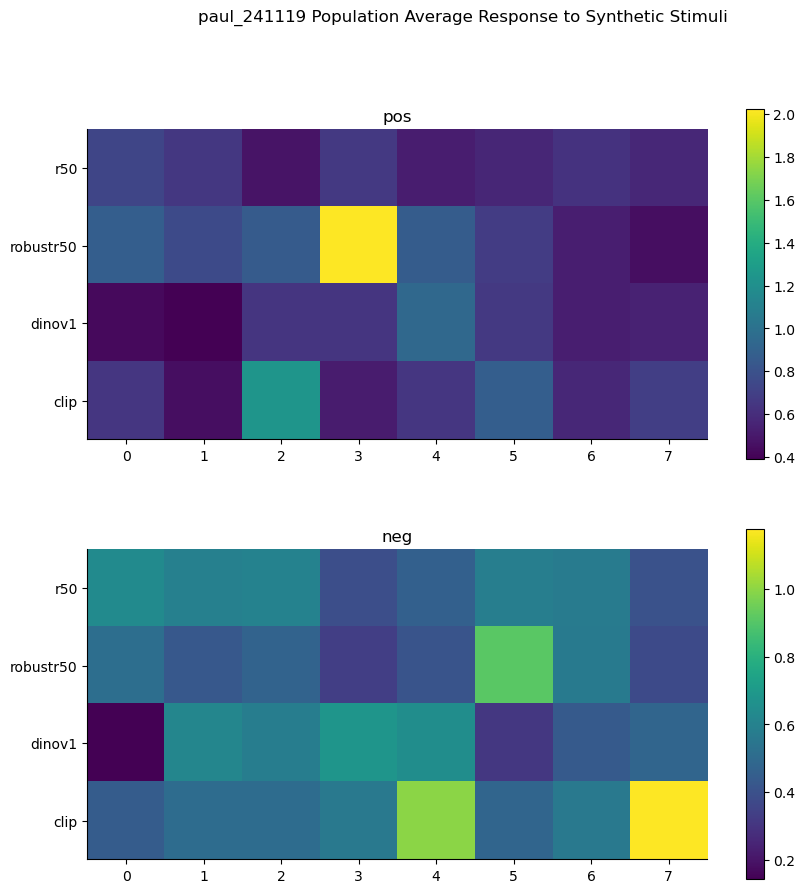

In [11]:
syn_stim_resp_tsr = rspavg_resp_peak[syn_stim_idxs, :,]
print(syn_stim_resp_tsr.shape)
syn_stim_resp_popavg = syn_stim_resp_tsr.mean(axis=-1)
figh, axh = plt.subplots(2, 1, figsize=(10, 10))
plt.sca(axh[0])
plt.imshow(syn_stim_resp_popavg[:,0,:].T)
plt.yticks([0,1,2,3], model_names)
plt.colorbar()
plt.title("pos")
plt.sca(axh[1])
plt.imshow(syn_stim_resp_popavg[:,1,:].T)
plt.yticks([0,1,2,3], model_names)
plt.colorbar()
plt.title("neg")
plt.suptitle(f"{subject_id} Population Average Response to Synthetic Stimuli")
plt.show()

In [6]:
subject_id = 'paul_240713-240710'
trials_resp_peak = data[subject_id]['trials']['response_peak']
trials_stim_names = data[subject_id]['trials']['stimulus_name']
rspavg_resp_peak = data[subject_id]['repavg']['response_peak']
rspavg_stim_names = data[subject_id]['repavg']['stimulus_name']

print(trials_resp_peak.shape, trials_stim_names.shape) # (29769, 383) (29769,)
print(rspavg_resp_peak.shape, rspavg_stim_names.shape) # (383, 1000) (383,)

# create a tensor, stimulus by neuron by trial
# using trials_stim_names find the index of the stimulus in rspavg_stim_names
# then use that index to index into rspavg_resp_peak
# then stack trials_resp_peak and the rspavg_resp_peak along the trial dimension

(29769, 383) (29769,)
(1110, 383) (1110,)


In [6]:
from core.data_utils import load_from_hdf5
dataroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation"
subject_id = 'paul_240713-240710'
resp_tensor, trial_counters = load_neural_trial_resp_tensor(data_path, subject_id)

Trials shape: (29769,) (29769, 383)
Rspavg shape: (1110,)
Response tensor shape (stimulus x neuron x trial): (1110, 383, 29)
Response tensor shape: (1110, 383, 29)
Trial counters shape: (1110,)
min and max trial counters: 26 29


In [7]:
# Create a dictionary mapping stimulus names to indices
stim_to_idx = {name.decode('utf8'): i for i, name in enumerate(rspavg_stim_names)}

# Initialize list to store trial counts for each stimulus
trial_counts = np.zeros(len(rspavg_stim_names), dtype=int)
# Count trials per stimulus
for stim_name in trials_stim_names:
    trial_counts[stim_to_idx[stim_name.decode('utf8')]] += 1
max_trials = trial_counts.max()
# Initialize 3D tensor (stimulus x neuron x trial)
resp_tensor = np.full((len(rspavg_stim_names), trials_resp_peak.shape[1], max_trials), np.nan)
trial_counters = np.zeros(len(rspavg_stim_names), dtype=int)
# Fill in the tensor with trial responses
for trial_idx, (stim_name, trial_resp) in enumerate(zip(trials_stim_names, trials_resp_peak)):
    stim_idx = stim_to_idx[stim_name.decode('utf8')]
    resp_tensor[stim_idx, :, trial_counters[stim_idx]] = trial_resp
    trial_counters[stim_idx] += 1

print(f"Response tensor shape (stimulus x neuron x trial): {resp_tensor.shape}")

Response tensor shape (stimulus x neuron x trial): (1110, 383, 29)


In [8]:
resp_tensor.shape

(1110, 383, 29)

In [10]:
trial_counters.min(), trial_counters.max()

(26, 29)

In [12]:
# chekc no nan 
print(np.isnan(resp_tensor).sum())
print(np.isnan(resp_tensor[:, :, :26]).sum())


927243
0


In [13]:
resp_tensor.dtype

dtype('float64')

In [14]:
dataroot

'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation'

In [15]:
np.save(join(dataroot, f"{subject_id}_trial_resp_tensor.npy"), resp_tensor)

In [17]:
!du -sh {dataroot}/*

8.0K	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/model_outputs
6.4G	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/nsd_shared1000_6monkeys_2024.h5
65G	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/paul_240713-240710
95M	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/paul_240713-240710_trial_resp_tensor.npy
339M	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/shared1000
336M	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/shared1000_images.tar.gz
3.1G	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/stimuli_pilot_20241119


In [18]:
from sklearn.model_selection import train_test_split, GridSearchCV
idx_train, idx_test = train_test_split(
        np.arange(1110), test_size=0.2, random_state=42, shuffle=True
    )
np.savez(join(dataroot, f"{subject_id}_trial_resp_tensor_train_test_idx.npz"), idx_train=idx_train, idx_test=idx_test)